In [1]:
import keras
import keras.backend as K
from keras import backend as K
from keras.models import Model, load_model

Using TensorFlow backend.


In [52]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
import pandas as pd
import re
import time
import os

In [53]:
def plot_2d_landmarks(img, true, pred):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    ax.imshow(img.reshape((80,120,3)).astype(np.float32))
    ax.autoscale(False)
    ax.plot(pred[:,0], pred[:,1], '.w', markersize=5)
    plt.plot(true[:,0], true[:,1], 'sr', markersize=3)
    ax.axis('off')
    plt.show()


def plot_3d_landmarks(true, pred, gaze_vector):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    Z = true
    ax.plot(np.hstack((Z[0:12,0], Z[0,0])) , np.hstack((Z[0:12,1], Z[0,1])), np.hstack((Z[0:12,2], Z[0,2])), c='r', marker='.')
    ax.plot(np.hstack((Z[12:20,0], Z[12,0])) , np.hstack((Z[12:20,1], Z[12,1])), np.hstack((Z[12:20,2], Z[12,2])), c='b', marker='.')
    ax.plot(np.hstack((Z[20:28,0], Z[20,0])) , np.hstack((Z[20:28,1], Z[20,1])), np.hstack((Z[20:28,2], Z[20,2])), c='g', marker='.')
    
    Z = np.vstack((np.mean(Z[20:28,:], axis=0), np.mean(Z[20:28,:], axis=0) - 0.1 * gaze_vector))
    ax.plot(Z[:,0], Z[:,1], Z[:,2], c='k', marker='^', linewidth=2.0)
    
    Z = pred
    ax.plot(np.hstack((Z[0:12,0], Z[0,0])) , np.hstack((Z[0:12,1], Z[0,1])), np.hstack((Z[0:12,2], Z[0,2])), c='r', marker='s', ls = 'dashed')
    ax.plot(np.hstack((Z[12:20,0], Z[12,0])) , np.hstack((Z[12:20,1], Z[12,1])), np.hstack((Z[12:20,2], Z[12,2])), c='b', marker='s', ls = 'dashed')
    ax.plot(np.hstack((Z[20:28,0], Z[20,0])) , np.hstack((Z[20:28,1], Z[20,1])), np.hstack((Z[20:28,2], Z[20,2])), c='g', marker='s', ls = 'dashed')
    
    ax.axis('off')
    plt.show()


def p_norm_loss(y_true, y_pred):
    return K.mean(K.pow(y_pred - y_true, 4), axis=-1)
    
def p_norm_loss(y_true, y_pred):
    return K.mean(K.pow(y_pred - y_true, 4), axis=-1)

def landmark_accuracy(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred) < 3.)
    
def landmark_accuracy_n(y_true, y_pred, n):
    diff = np.abs(y_true - y_pred)
    points = np.sum(diff, axis=2)
    mask = points < n
    return np.mean(points < n)

def landmark_loss(y_true, y_pred):
    return K.mean( K.square(y_true - y_pred) * K.sigmoid( K.abs(y_true - y_pred) - 1 ), axis=-1)

def model_predict(model, test_inputs, num_samples, output_dims):
    t0 = time.time()
    pred = model.predict(test_inputs)
    print(time.time() - t0)
    return np.reshape(pred, (num_samples, 28, output_dims))

def load_model_and_predict(filepath, test_inputs, custom_objects, num_samples, output_dims=2):
    model = load_model(filepath, custom_objects)
    pred = model_predict(model, test_inputs, num_samples, output_dims)
    return model, pred

def load_all_models(model_type = 'augmented'):
    models = []
    
    for path in glob.glob('./models/%s/*.history' % model_type):
        with open(path, 'rb') as f:
#             print(path)
            history = pickle.load(f)
            if len(history['val_loss']) == 70:
                model = load_model(path.replace('.history' , '.h5'), custom_objects)
                models.append((path, model, history))
        
    return models
        
def parse_model_desc(full_path):
    desc = re.findall(r'.*\\(.+).history', full_path)
    headpose, topology, dims, objective, losses = desc[0].split('-')
    return {'headpose': headpose,'topology': topology, 'dims': dims,'objective':  objective,'losses': losses}

In [4]:
# Initialization

# Load data
with open('all_data_augmented.pkl', 'rb') as f:
    images_train ,images_test, ldmks_2d_train , ldmks_2d_test , augmented_images_train, \
    augmented_images_test, augmented_ldmks_2d_train, augmented_ldmks_2d_test, ldmks_3d_train ,\
    ldmks_3d_test , head_pose_train ,head_pose_test, look_vec_train, look_vec_test = pickle.load(f)
    
with open('all_data_augmented_bw.pkl', 'rb') as f:
    bw_images_train , bw_images_test, _, _ , bw_augmented_images_train, \
    bw_augmented_images_test, _, _, _ , _ , _ ,_, _, _ = pickle.load(f)
    
# Params
num_samples = images_test.shape[0]
    
# Feed-forward params
test_inputs = {'input_img': images_test, 'head_pose': head_pose_test}
bw_test_inputs = {'input_img': bw_images_test, 'head_pose': head_pose_test}
augmented_test_inputs = {'input_img': augmented_images_test, 'head_pose': head_pose_test}
bw_augmented_test_inputs = {'input_img': bw_augmented_images_test, 'head_pose': head_pose_test}
all_test_inputs = {'input_img': np.vstack((images_test, augmented_images_test)), 'head_pose': np.vstack((head_pose_test, head_pose_test))}
bw_all_test_inputs = {'input_img': np.vstack((bw_images_test, bw_augmented_images_test)), 'head_pose': np.vstack((head_pose_test, head_pose_test))}
custom_objects={'p_norm_loss': p_norm_loss, 'landmark_accuracy' : landmark_accuracy, 'landmark_loss': landmark_loss}

# Reshape for original dimensions for plotting
all_ldmks_2d_test = np.reshape(np.vstack((ldmks_2d_test, augmented_ldmks_2d_test)), (num_samples * 2, 28, 2))
ldmks_2d_test = np.reshape(ldmks_2d_test, (num_samples, 28, 2))
augmented_ldmks_2d_test = np.reshape(augmented_ldmks_2d_test, (num_samples, 28, 2))
ldmks_3d_test = np.reshape(ldmks_3d_test, (num_samples, 28, 3))
head_pose_test_raw = np.reshape(head_pose_test, (num_samples, 3,3))

In [5]:
# Correct file naming

for path in glob.glob('./models/transferlearning/*augmentedtransfer*'):
    os.rename(path, path.replace('augmentedtransfer-', ''))
    
for path in glob.glob('./models/augmented/Augmented*'):
    os.rename(path, path.replace('Augmented', ''))


In [6]:
# Load models
synthetic_models = load_all_models('synthetic')
transfer_models = load_all_models('transferlearning')
bw_models = load_all_models('bw')
augmented_models = load_all_models('augmented')
L3D_models = load_all_models('3D')

In [7]:
d_synthetic = [{**parse_model_desc(x[0]), ** x[2]} for x in synthetic_models ]
d_transfer =  [{**parse_model_desc(x[0]), ** x[2]} for x in transfer_models ]
d_augmented =  [{**parse_model_desc(x[0]), ** x[2]} for x in augmented_models ]
d_3d =  [{**parse_model_desc(x[0]), ** x[2]} for x in L3D_models ]
d_bw =  [{**parse_model_desc(x[0]), ** x[2]} for x in bw_models ]

df_synthetic = pd.DataFrame(d_synthetic)
df_transfer = pd.DataFrame(d_transfer)
df_augmented = pd.DataFrame(d_augmented)
df_3d = pd.DataFrame(d_3d)
df_bw = pd.DataFrame(d_bw)

In [21]:
df_2d['final_val_landmark_accuracy'] = [x[-1] for x in df_2d['val_landmark_accuracy']]
df_3d['final_val_loss'] = [x[-1] for x in df_3d['val_loss']]

In [22]:
df_2d['losses'].apply(lambda x: eval(x))

9      [1.869929988288963, 0.9473540021967982]
11      [2.91190018201534, 0.9265951693555373]
1     [1.2747496417807445, 0.9242346040973236]
10      [1.40338808834736, 0.9134826713556986]
2      [3.299737687795687, 0.9107613592855649]
0      [2.829588950805932, 0.9050442511751613]
14    [4.0236392957262685, 0.8828894716111201]
13    [1.5395265228663508, 0.8776037026038022]
3      [4.387020204064089, 0.8447205096313081]
12     [4.328807466010226, 0.8402189781752709]
4     [1.7732048275494816, 0.8292631476816504]
16    [1.8368063820628258, 0.8183622143747098]
15     [5.334857097151618, 0.8114530520843318]
5       [6.273642340615281, 0.796419174513065]
8       [7.06650057077722, 0.7854006049608944]
7     [2.0011195341222474, 0.7831027809339078]
17        [7.865583745649, 0.7726096528687392]
6      [7.252880745411548, 0.7509254111916965]
Name: losses, dtype: object

In [71]:
# with open('results.dataframe', 'wb') as f:
#     pickle.dump((df_2d, df_3d),f)

In [4]:
with open('results.dataframe', 'rb') as f:
    df_2d, df_3d = pickle.load(f)

In [5]:
df_2d.sort_values('final_val_landmark_accuracy', ascending = False, inplace=True)
df_2d

,dims,headpose,landmark_accuracy,loss,losses,objective,topology,val_landmark_accuracy,val_loss,final_val_landmark_accuracy,model_name
9,2D,H,"[0.196887508112, 0.347866173651, 0.45283793660...","[421.502155307, 58.2627097191, 33.8221064283, ...","[1.8699299882889631, 0.94735400219679822]",LL,TT,"[0.31782107777, 0.38144646176, 0.516539640525,...","[67.156550644, 47.8593130618, 24.4332026556, 1...",0.947354,TT-LL-H
11,2D,H,"[0.195606815063, 0.339403398835, 0.38254296125...","[422.288648753, 60.0191145422, 46.731460909, 3...","[2.9119001820153398, 0.92659516935553732]",MSE,TT,"[0.312292180029, 0.342689327415, 0.43685301487...","[67.033681103, 58.0991577999, 35.5421009767, 2...",0.926595,TT-MSE-H
1,2D,NH,"[0.189034683712, 0.407788119605, 0.56814547862...","[16.2755287211, 5.10000194726, 3.36483834875, ...","[1.2747496417807445, 0.92423460409732361]",MAE,TT,"[0.297838641106, 0.479311777407, 0.62330609976...","[6.56583620929, 4.1895442343, 2.91692799521, 2...",0.924235,TT-MAE-NH
10,2D,H,"[0.188259987776, 0.385045512917, 0.52275439856...","[14.6418838091, 5.35233000892, 3.82419904283, ...","[1.40338808834736, 0.91348267135569861]",MAE,TT,"[0.296442694291, 0.397531218221, 0.57680065348...","[6.51771025182, 5.0783378034, 3.27597287291, 2...",0.913483,TT-MAE-H
2,2D,NH,"[0.209904299989, 0.353249794314, 0.42621990895...","[400.770902203, 54.9562075297, 35.5792257524, ...","[3.299737687795687, 0.9107613592855649]",MSE,TT,"[0.302528400601, 0.36998087563, 0.49109105256,...","[67.3284483898, 46.8249388147, 25.4947326268, ...",0.910761,TT-MSE-NH
0,2D,NH,"[0.174158630967, 0.339066065094, 0.41662745746...","[484.128217676, 56.2379975723, 39.1151242685, ...","[2.829588950805932, 0.9050442511751613]",LL,TT,"[0.291909792966, 0.382050322711, 0.47037927778...","[72.2709450418, 44.139924632, 29.932696889, 16...",0.905044,TT-LL-NH
14,2D,H,"[0.113052096326, 0.245557786249, 0.32580216033...","[602.064184745, 107.526403553, 55.3070270637, ...","[4.0236392957262685, 0.88288947161112008]",MSE,NS,"[0.159914366639, 0.289549229409, 0.31973462524...","[206.551881558, 64.5643474527, 54.6213355954, ...",0.882890,NS-MSE-H
13,2D,H,"[0.10413823205, 0.268622036228, 0.342686524878...","[20.5772232908, 7.569979452, 5.71517700895, 5....","[1.5395265228663508, 0.87760370260380216]",MAE,NS,"[0.156416656563, 0.307555378085, 0.30410472086...","[11.9215608294, 6.42320195844, 6.30679494852, ...",0.877604,NS-MAE-H
3,2D,NH,"[0.106534874673, 0.259208057684, 0.32753001560...","[711.034309215, 93.1059001162, 55.3578001606, ...","[4.3870202040640889, 0.84472050963130807]",LL,NS,"[0.170391812934, 0.315405616961, 0.29467815815...","[181.534348157, 57.512084192, 68.5324245364, 4...",0.844721,NS-LL-NH
12,2D,H,"[0.113532600637, 0.25855300089, 0.337381353122...","[622.984404616, 99.6648166319, 52.0935774634, ...","[4.3288074660102263, 0.84021897817527091]",LL,NS,"[0.178547909929, 0.308096499233, 0.33220403653...","[177.95127423, 58.212658999, 55.0938155334, 52...",0.840219,NS-LL-H


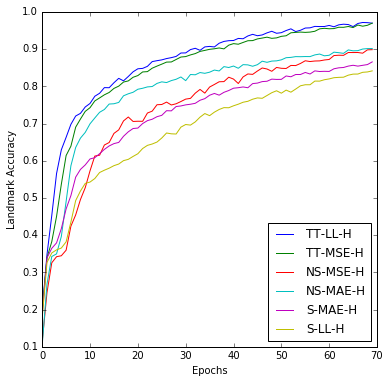

In [6]:
plt.figure(figsize=(6,6))

for topology in df_2d.topology.unique():
    top_2 = df_2d[df_2d.topology == topology][:2]
    
    for i, row in top_2.iterrows():
        plt.plot(row.landmark_accuracy, label = '%s-%s-%s' % (row.topology, row.objective, row.headpose))
    
plt.legend(loc= 'lower right')
plt.ylabel('Landmark Accuracy')
plt.xlabel('Epochs')
plt.show()

In [7]:
table_2d = df_2d[['model_name', 'topology', 'objective', 'headpose', 'final_val_landmark_accuracy']]
table_2d

,model_name,topology,objective,headpose,final_val_landmark_accuracy
9,TT-LL-H,TT,LL,H,0.947354
11,TT-MSE-H,TT,MSE,H,0.926595
1,TT-MAE-NH,TT,MAE,NH,0.924235
10,TT-MAE-H,TT,MAE,H,0.913483
2,TT-MSE-NH,TT,MSE,NH,0.910761
0,TT-LL-NH,TT,LL,NH,0.905044
14,NS-MSE-H,NS,MSE,H,0.882890
13,NS-MAE-H,NS,MAE,H,0.877604
3,NS-LL-NH,NS,LL,NH,0.844721
12,NS-LL-H,NS,LL,H,0.840219


In [14]:
print(table_2d[['model_name', '']].to_latex(index=False))

\begin{tabular}{llllr}
\toprule
model\_name & topology & objective & headpose &  final\_val\_landmark\_accuracy \\
\midrule
   TT-LL-H &       TT &        LL &        H &                     0.947354 \\
  TT-MSE-H &       TT &       MSE &        H &                     0.926595 \\
 TT-MAE-NH &       TT &       MAE &       NH &                     0.924235 \\
  TT-MAE-H &       TT &       MAE &        H &                     0.913483 \\
 TT-MSE-NH &       TT &       MSE &       NH &                     0.910761 \\
  TT-LL-NH &       TT &        LL &       NH &                     0.905044 \\
  NS-MSE-H &       NS &       MSE &        H &                     0.882890 \\
  NS-MAE-H &       NS &       MAE &        H &                     0.877604 \\
  NS-LL-NH &       NS &        LL &       NH &                     0.844721 \\
   NS-LL-H &       NS &        LL &        H &                     0.840219 \\
 NS-MAE-NH &       NS &       MAE &       NH &                     0.829263 \\
   S-MA

In [9]:
model = load_model(model_path, custom_objects)

In [5]:
model_path = 'models\ignore\wrong_landmark\HeadTrue-double_tower-2D-mean_squared_error-[2.9119001820153398, 0.92659516935553732].h5'

with open(model_path.replace('h5', 'history'), 'rb') as f:
    hist = pickle.load(f)

model, preds = load_model_and_predict(model_path, 
    augmented_test_inputs, custom_objects, num_samples, output_dims=2)

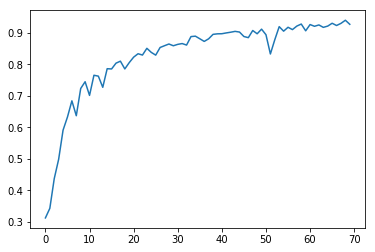

In [6]:
plt.plot(hist['val_landmark_accuracy'])          
plt.show()

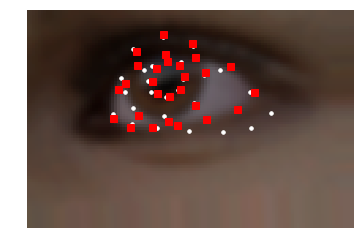

In [28]:
i = np.random.choice(num_samples)
plot_2d_landmarks(augmented_images_test[i,:,:,:], augmented_ldmks_2d_test[i,:,:], preds[i,:,:])

In [39]:


plot_3d_landmarks(ldmks_3d_test[i,:,:], pred_landmarks_3D[i,:,:], look_vec_test[i,:])

NameError: name 'pred_landmarks_3D' is not defined

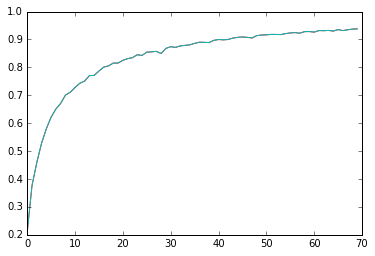

In [7]:
with open('models/HeadTrue-TowerTrue-2D-mean_absolute_error-non_spatial-[1.3430979573836597, 0.91167892365796976].history', 'rb') as f:
    hist_doubletower_mae = pickle.load(f)
    
plt.plot(hist_doubletower_mae['landmark_accuracy'])
plt.show()

In [1]:
import pickle
import matplotlib.pyplot as plt
with open('models/HeadTrue-TowerFalse-2D-landmark_loss-non_spatial-[4.910250957147249, 0.8166212013640004].history', 'rb') as f:
    history_landmark = pickle.load(f)
    
with open('models/HeadTrue-TowerFalse-2D-mean_absolute_error-non_spatial-[2.0025351818161781, 0.7804442103567697].history', 'rb') as f:
    history_mae = pickle.load(f)

with open('models/HeadTrue-TowerFalse-2D-mean_squared_error-non_spatial-[5.4612291761799554, 0.81560168234360653].history', 'rb') as f:
    history_mse = pickle.load(f)
    
with open('models/HeadFalse-TowerFalse-2D-landmark_loss-non_spatial-[6.0355695522192754, 0.7780914918131403].history', 'rb') as f:
    history_landmark_nohead = pickle.load(f)
    
with open('models/HeadFalse-TowerFalse-2D-mean_absolute_error-non_spatial-[1.7898727505155756, 0.82330292499950175].history', 'rb') as f:
    history_mae_nohead = pickle.load(f)
    
with open('models/HeadFalse-TowerFalse-2D-mean_squared_error-non_spatial-[7.0365000420303581, 0.76336346098766239].history', 'rb') as f:
    history_mse_nohead = pickle.load(f)

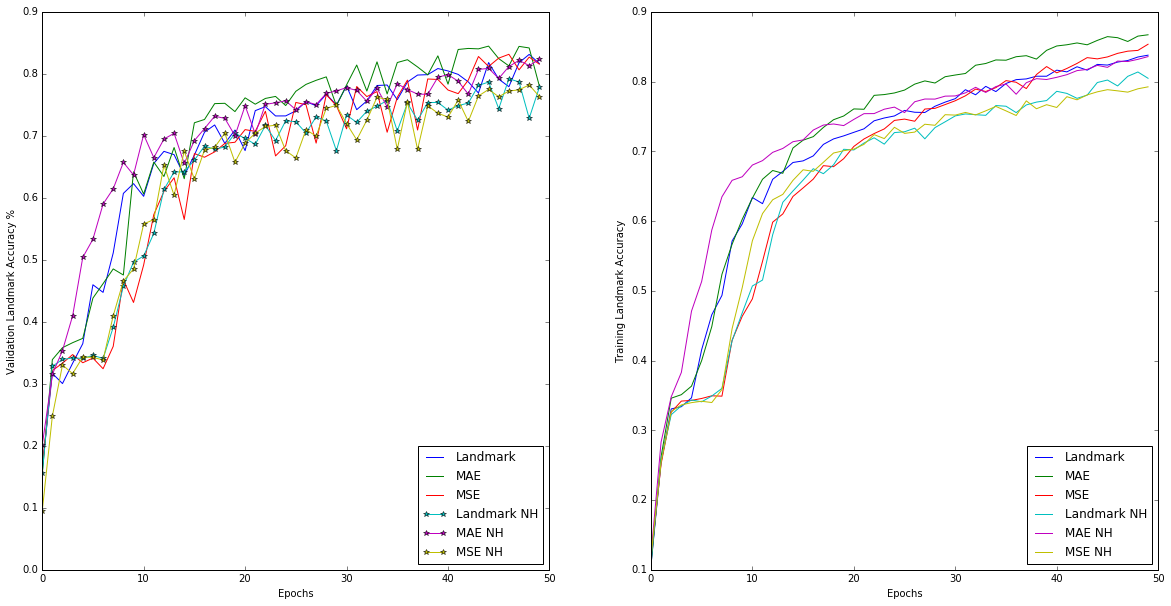

In [2]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(history_landmark['val_landmark_accuracy'], label='Landmark')
plt.plot(history_mae['val_landmark_accuracy'], label='MAE')
plt.plot(history_mse['val_landmark_accuracy'], label='MSE')

plt.plot(history_landmark_nohead['val_landmark_accuracy'], '*-', label='Landmark NH')
plt.plot(history_mae_nohead['val_landmark_accuracy'], '*-', label='MAE NH')
plt.plot(history_mse_nohead['val_landmark_accuracy'], '*-', label='MSE NH')

plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Validation Landmark Accuracy %')

plt.subplot(1,2,2)
plt.plot(history_landmark['landmark_accuracy'], label='Landmark')
plt.plot(history_mae['landmark_accuracy'], label='MAE')
plt.plot(history_mse['landmark_accuracy'], label='MSE')

plt.plot(history_landmark_nohead['landmark_accuracy'], label='Landmark NH')
plt.plot(history_mae_nohead['landmark_accuracy'], label='MAE NH')
plt.plot(history_mse_nohead['landmark_accuracy'], label='MSE NH')

plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Training Landmark Accuracy')
plt.show()

In [8]:
def load_history(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

path = './models/bw/HeadFalse-spatial-2D-mean_squared_error-[2.841274347020494, 0.92591288972434949].h5'
model = load_model(path, custom_objects)
hist = load_history(path.replace('.h5', '.history'))

In [54]:
preds_augmented = model_predict(model, bw_augmented_test_inputs, len(bw_augmented_test_inputs['input_img']), output_dims=2)
preds_synthetic = model_predict(model, bw_test_inputs, len(bw_test_inputs['input_img']), output_dims=2)
preds_all = model_predict(model, bw_all_test_inputs, len(bw_all_test_inputs['input_img']), output_dims=2)

1.291370153427124


In [91]:
point = bw_augmented_test_inputs['input_img'][0,:,:,:]
model_predict(model, {'input_img': point[np.newaxis, :,:,:], 'headpose': head_pose_test[0]}, 1, output_dims=2)

0.00299835205078125


array([[[ 40.48609924,  46.44623947],
        [ 48.17007446,  44.34227371],
        [ 57.46425247,  43.55897141],
        [ 68.79557037,  42.37031174],
        [ 79.17420959,  40.80198669],
        [ 86.35947418,  39.01316071],
        [ 92.86360931,  37.88844681],
        [ 87.39635468,  44.6909256 ],
        [ 80.75704193,  50.26172638],
        [ 71.41333771,  53.65415192],
        [ 60.39097214,  53.90262604],
        [ 49.28598404,  51.58028793],
        [ 51.51404953,  50.51700592],
        [ 54.94861603,  39.44000244],
        [ 65.19013214,  32.62096786],
        [ 76.18434143,  34.36012268],
        [ 81.73782349,  43.34922028],
        [ 78.15707397,  54.58811188],
        [ 67.97259521,  61.24613953],
        [ 56.16592407,  60.11065292],
        [ 61.83462906,  51.55664444],
        [ 66.71578217,  52.34140778],
        [ 71.22665405,  49.28398132],
        [ 72.70718384,  44.34283066],
        [ 70.38578033,  40.20767212],
        [ 65.51672363,  39.53448105],
        [ 60

In [94]:
point = bw_augmented_test_inputs['input_img'][:1000,:,:,:]
model_predict(model, {'input_img': point, 'headpose': head_pose_test[:1000]}, 1000, output_dims=2)

0.4872884750366211


array([[[ 40.48610306,  46.44622421],
        [ 48.17008209,  44.3422699 ],
        [ 57.46426773,  43.55897141],
        ..., 
        [ 65.516716  ,  39.53447723],
        [ 60.95025635,  42.51451874],
        [ 59.35402298,  47.57670593]],

       [[ 33.86711121,  25.22323418],
        [ 37.60531998,  19.20156288],
        [ 44.31617737,  12.58059788],
        ..., 
        [ 54.38500214,   1.42949307],
        [ 50.28681564,   4.53164911],
        [ 49.34563446,   9.1614151 ]],

       [[ 30.50052071,  38.97751999],
        [ 35.75526428,  29.02998161],
        [ 44.19959259,  21.1811161 ],
        ..., 
        [ 72.45105743,  25.74559021],
        [ 67.90394592,  27.20891571],
        [ 66.31452942,  31.54395866]],

       ..., 
       [[ 23.49578094,  48.42665863],
        [ 29.72658539,  43.68567657],
        [ 38.31138992,  40.54376602],
        ..., 
        [ 34.33639145,  40.25337601],
        [ 30.28820229,  41.78788757],
        [ 28.24393272,  46.52914047]],

       [[ 2

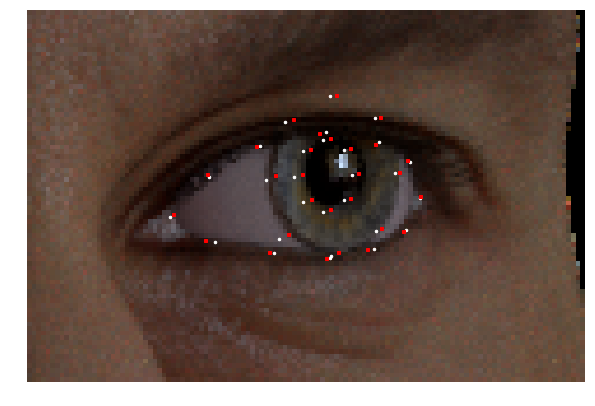

In [51]:
i = np.random.choice(len(preds_augmented))
plot_2d_landmarks(images_test[i,:,:,:], ldmks_2d_test[i,:,:], preds_synthetic[i,:,:])

In [55]:
window_sizes = list(range(1, 11))

augmented_sensitivity = [landmark_accuracy_n(augmented_ldmks_2d_test, preds_augmented, n) for n in window_sizes]
synthetic_sensitivity = [landmark_accuracy_n(ldmks_2d_test, preds_synthetic, n) for n in window_sizes]
all_sensitivity = [landmark_accuracy_n(all_ldmks_2d_test, preds_all, n) for n in window_sizes]

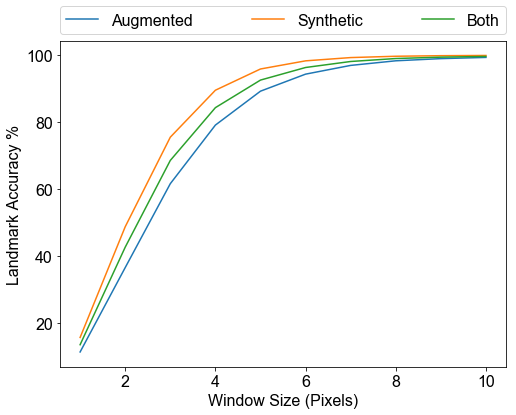

In [155]:
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})
plt.figure(figsize=(8,6))
plt.plot(window_sizes, 100 * np.array(augmented_sensitivity), label='Augmented')
plt.plot(window_sizes, 100* np.array(synthetic_sensitivity), label='Synthetic')
plt.plot(window_sizes, 100 * np.array(all_sensitivity), label='Both')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel('Window Size (Pixels)')
plt.ylabel('Landmark Accuracy %')
plt.show()

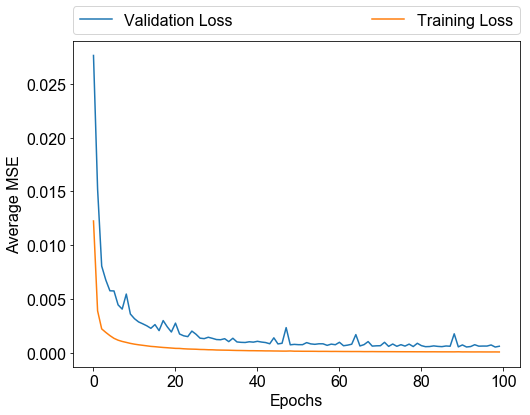

In [81]:
plt.figure(figsize=(8,6))
plt.plot(list(range(100)), np.array(hist['val_loss']) / len(all_ldmks_2d_test), label='Validation Loss')
plt.plot(list(range(100)), np.array(hist['loss']) / (len(images_train) * 2), label='Training Loss')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Average MSE')
plt.show()

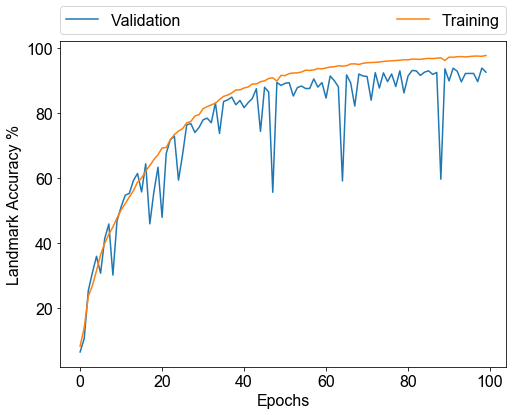

In [148]:
plt.figure(figsize=(8,6))
plt.plot(list(range(100)), 100 * np.array(hist['val_landmark_accuracy']) , label='Validation')
plt.plot(list(range(100)), 100 * np.array(hist['landmark_accuracy']) , label='Training')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Landmark Accuracy %')
plt.show()

In [136]:
def adaptive_accuracy(y_true, y_pred, ratio):

    score = []
    N = len(y_true)

    for i in range(N):
        lids = y_true[i,:12, 0] # x-values of lids
        diff = (max(lids) - min(lids)) * ratio

        pred = y_pred[i,:,:]
        true = y_true[i,:,:]

        score.append(landmark_accuracy_n(true[np.newaxis, :, :], pred[np.newaxis, :, :], diff))
        
    return np.mean(score)

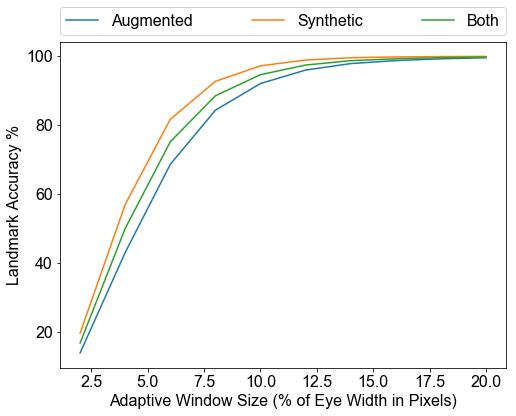

In [156]:
ratios = np.linspace(0.02, 0.2, 10)

augmented_sensitivity_adap = [adaptive_accuracy(augmented_ldmks_2d_test, preds_augmented, n) for n in ratios]
synthetic_sensitivity_adap = [adaptive_accuracy(ldmks_2d_test, preds_synthetic, n) for n in ratios]
all_sensitivity_adap = [adaptive_accuracy(all_ldmks_2d_test, preds_all, n) for n in ratios]

plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})
plt.figure(figsize=(8,6))
plt.plot(ratios * 100 , np.array(augmented_sensitivity_adap) * 100, label='Augmented')
plt.plot(ratios * 100, np.array(synthetic_sensitivity_adap )* 100, label='Synthetic')
plt.plot(ratios * 100, np.array(all_sensitivity_adap) * 100, label='Both')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel('Adaptive Window Size (% of Eye Width in Pixels)')
plt.ylabel('Landmark Accuracy %')
plt.show()